In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, collapse_mask
import pickle
import hypertools as hyp
import numpy as np
from scipy.spatial.distance import pdist, cdist,squareform
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from nltools.plotting import plotBrain
from nltools.stats import threshold
%matplotlib inline

In [31]:
base_dir = '/mnt'
data_dir = os.path.join(base_dir,'data')
roi_dir = os.path.join(data_dir,'rois')
mask_dir = os.path.join(base_dir,'masks')
mni_mask = os.path.join(mask_dir,'MNI152_T1_3mm_brain_mask.nii.gz')
rois = glob(os.path.join(mask_dir,'k50*'))[0]
social_features = pd.read_csv(os.path.join(data_dir,'social_features_with_pca.csv'))
scene_data = pd.read_excel(os.path.join(data_dir,'Sherlock_Movie_Scenes_only.xlsx'))
#scene_data_full = pd.concat([scene_data[scene_data.columns[:-1]],social_features[social_features.columns[1:]]],axis=1)
#scene_data_full.to_csv(os.path.join(data_dir,'scene_data_complexity.csv'),index=False)
scene_data_full = pd.read_csv(os.path.join(data_dir,'scene_data_complexity.csv'),index=False)

In [3]:
#Jeremy's funcs not currently used
def io_ratio(observations, group_labels):
    group_labels = np.array(group_labels)
    unique_groups = np.unique(group_labels)
    in_group = 0.0
    out_group = 0.0
    
    for g in unique_groups:
        if np.sum(group_labels == g) == 0:
            continue
        
        in_obs = np.array(observations[group_labels == g, :], ndmin=2)
        out_obs = np.array(observations[group_labels != g, :], ndmin=2)
        
        in_group += np.mean(pdist(in_obs))
        out_group += np.mean(cdist(in_obs, out_obs))
    
    return in_group / out_group

def dynamic_kmeans_old(observations, minK, maxK, n, statfun=io_ratio):
    '''
    observations: T by V numpy array of observations
    minK, maxK: minimum and maximum values of K to use
    n: number of timepoints
    statfun: takes in an observations matrix and cluster labels; returns a clustering stat
    '''
    
    stats = np.zeros([observations.shape[0] - n + 1, maxK - minK])
    for t in np.arange(stats.shape[0]):
        next_obs = observations[t:(t+n), :]
        stats[t, :] = np.array(list(map(lambda k: statfun(next_obs.T, hyp.tools.cluster(next_obs.T, n_clusters=k)),
                                   np.arange(minK, maxK))))
    return stats

In [4]:
#Load in full ROI time series
sub_list = sorted(glob(os.path.join(roi_dir,'*ROI_0*')))
data = np.array([np.load(sub) for sub in sub_list])

In [42]:
#Compute subject-spatial similarity across time in ROI in case we need it
roi_corrs = Adjacency(np.array([pdist(data[:,i,:],metric='correlation') for i in range(data.shape[1])]))

In [58]:
#Compute scene-level average pattern for each subject
avg_scene_response = []
for i, row in scene_data_full.iterrows():
    avg_scene_response.append(data[:,row['Start Time (TRs, 1.5s)']:row['End Time (TRs, 1.5s)']+1,:].mean(axis=1))
avg_scene_response = np.array(scene_data)

In [114]:
def dynamic_kmeans(dat,kmin,kmax):
    '''
        Computer within cluster:between cluster SS ratio for a range of cluster sizes.
        
        Args:
            dat: obs X features matrix (e.g. subs X voxels)
            kmin: min cluster size
            kmax: max cluster size
        
        Outputs:
            gradient: average gradient of the change in wss/bss ratio over k
            ratio: array of wss/bss ratios
            labels: kmax-kmin X obs matrix of cluster label assigments
            
    '''

    k_range = range(kmax,kmin,-1)
    k_fits = [KMeans(n_clusters=k).fit(dat) for k in k_range]
    labels = np.array([k.labels_ for k in k_fits])
    
    centroids = [k.cluster_centers_ for k in k_fits]
    dist_to_centroid = [cdist(dat, cent, 'euclidean') for cent in centroids]
    dist = [np.min(d,axis=1) for d in dist_to_centroid]
    #Not sure if we need this
    avg_within_ss = [sum(d)/dat.shape[0] for d in dist]

    # Total with-in sum of square
    wss = [sum(d**2) for d in dist]
    tss = sum(pdist(dat)**2)/dat.shape[0]
    bss = tss-wss
    ratio = wss/bss
    
    #Gradient of the change in ratio as a function of k
    gradient = np.gradient(ratio)
    
    return gradient, ratio, labels, 


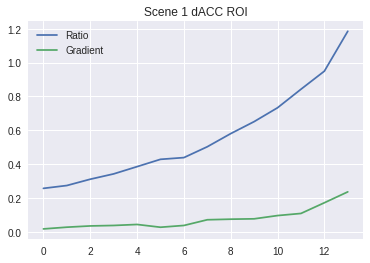

In [111]:
#Roi data for 1 scene
dat = avg_scene_response[:,0,:]
kmin, kmax = 2,16
gradient, ratio, labels = dynamic_kmeans(dat,kmin,kmax)
plt.plot(ratio,label='Ratio');
plt.plot(gradient,label='Gradient');
plt.legend();
plt.title("Scene 1 dACC ROI");

In [115]:
kmin, kmax = 2,8
roi_gradients = []
for scene in range(avg_scene_response.shape[0]):
    gradient, _, _ = dynamic_kmeans(avg_scene_response[scene,:,:],kmin,kmax)
    grad_var = gradient.var()
    roi_gradients.append(grad_var)
roi_gradients = np.array(roi_gradients)

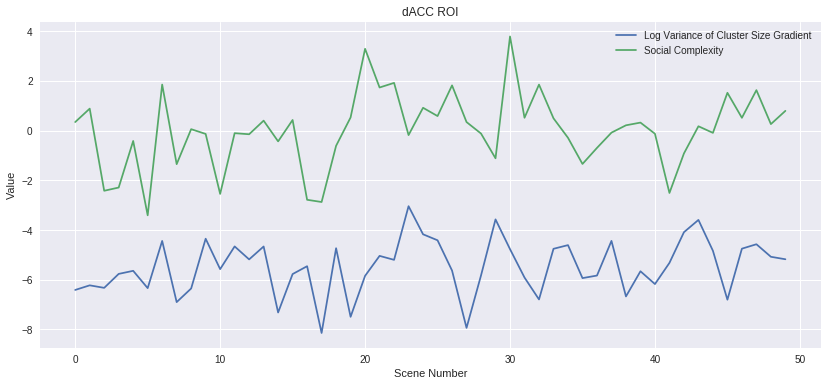

In [118]:
f,axs = plt.subplots(1,1,figsize=(14,6));

axs.plot(np.log(roi_gradients),color=sns.color_palette()[0],label='Log Variance of Cluster Size Gradient');
axs.plot(scene_data_full['component'].values, color = sns.color_palette()[1], label = 'Social Complexity');
axs.set(xlabel='Scene Number',ylabel='Value',title='dACC ROI');
plt.legend()

In [ ]:
#Run it for the whole brain correlating the entire scene-wise time-series
whole_brain_similarity = pd.DataFrame()
for roi in range(50):
    
    print("Analyzing ROI %s" % roi)
    
    #Load in full ROI time series
    sub_list = sorted(glob(os.path.join(roi_dir,'*ROI_'+str(roi)+'.npy')))
    data = np.array([np.load(sub) for sub in sub_list])
    
    #Compute scene-level average pattern for each subject
    avg_scene_response = []
    for i, row in scene_data_full.iterrows():
        avg_scene_response.append(data[:,row['Start Time (TRs, 1.5s)']:row['End Time (TRs, 1.5s)']+1,:].mean(axis=1))
    avg_scene_response = np.array(scene_data)
    
    #Compute all scene gradients
    kmin, kmax = 2,8
    roi_gradients = []
    for scene in range(avg_scene_response.shape[0]):
        gradient, _, _ = dynamic_kmeans(avg_scene_response[scene,:,:],kmin,kmax)
        grad_var = gradient.var()
        roi_gradients.append(grad_var)
    roi_gradients = np.array(roi_gradients)
    
    #Compute rank correlation
    r,p = spearmanr(np.log(roi_gradients),scene_data_full['component'].values)
    
    df = pd.DataFrame({'ROI': roi, 'Log_Gradient':np.log(roi_gradients),
                  'Social_Complexity':scene_data_full['component'].values,
                  'P-val': p,
                  'Corr': r,
                  'Scene': list(range(1,51))                       
                 })
    whole_brain_similarity = whole_brain_similarity.append(df,ignore_index=True)
    
    whole_brain_similarity.to_csv(os.path.join(data_dir,'whole_brain_similarity.csv'),index=False)

In [136]:
parcels = Brain_Data(rois,mask=mni_mask)
expanded_parcels = expand_mask(parcels)

corr_map = expanded_parcels.copy()
corrs = whole_brain_similarity.groupby('ROI')['Corr'].mean().values
corr_map.data = np.array([(x.data*y) for (x,y) in zip(expanded_parcels,corrs)])
corr_map = corr_map.sum()

p_map = expanded_parcels.copy()
ps = whole_brain_similarity.groupby('ROI')['P-val'].mean().values
p_map.data = np.array([(x.data*y) for (x,y) in zip(expanded_parcels,ps)])
p_map = p_map.sum()

#Completely arbitrary threshold
thresh_map = threshold(corr_map,p_map,thr=.2)

Plotting unthresholded image


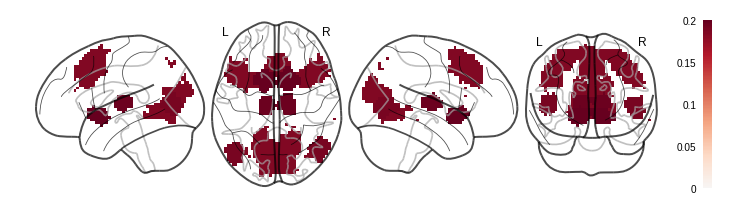

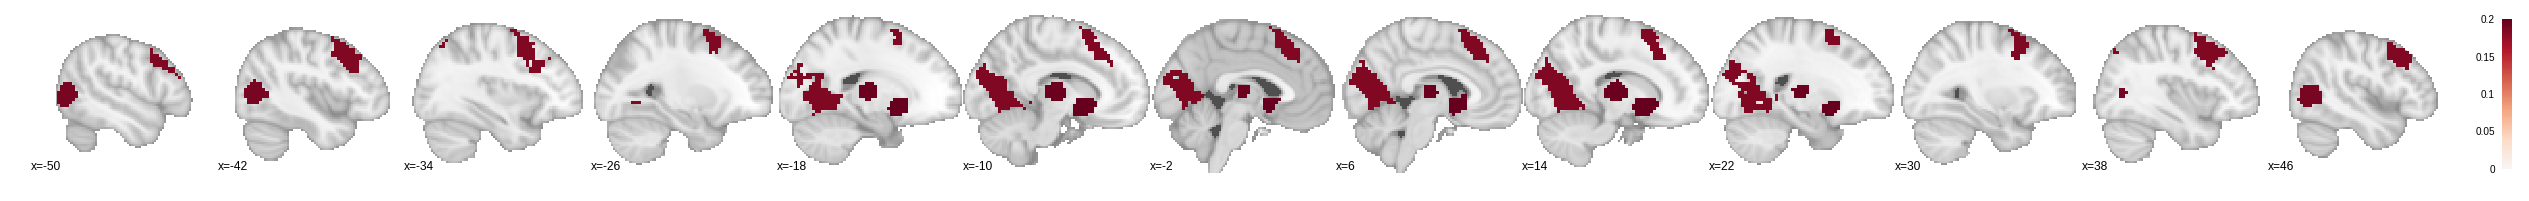

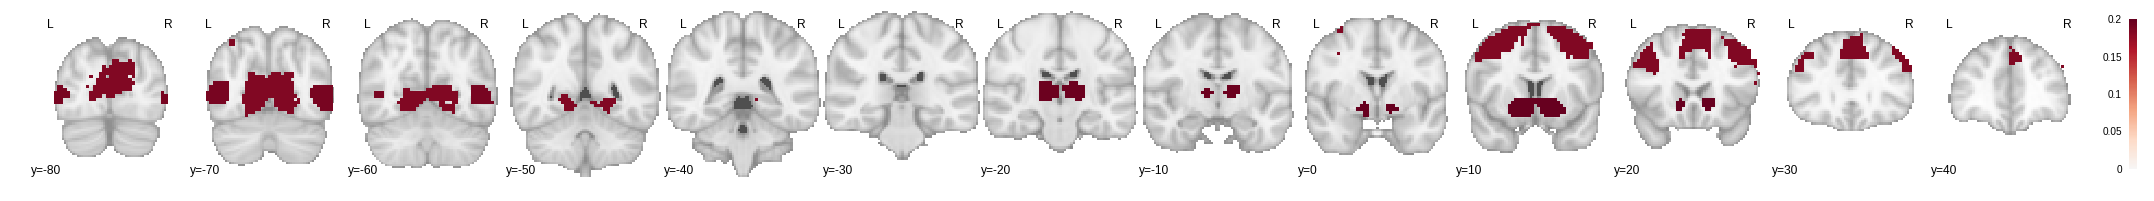

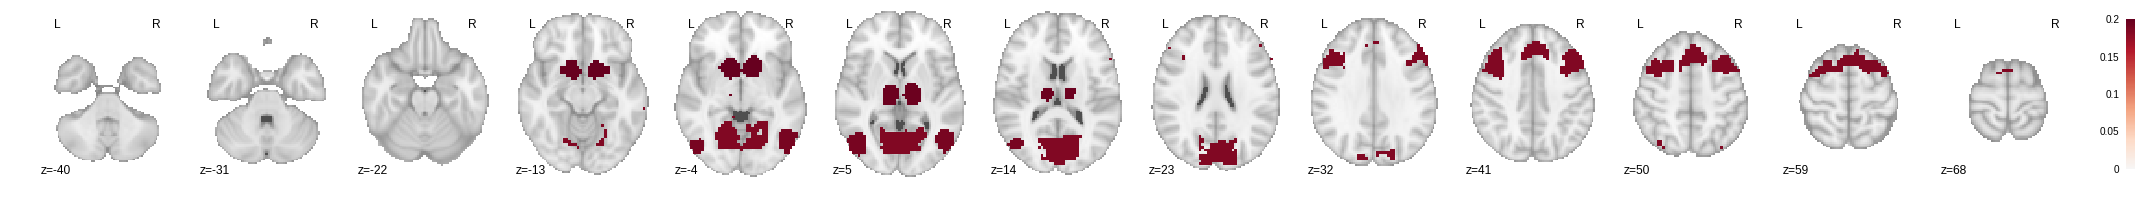

In [148]:
plotBrain(thresh_map)

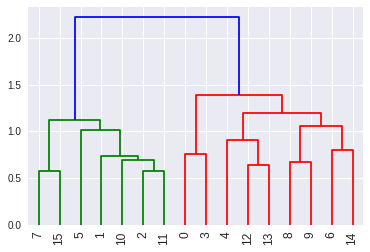

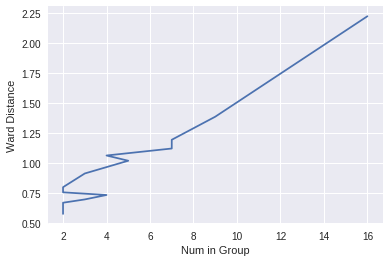

In [6]:
#Try ward clustering cause we get distances for a bunch of diff clusters
linkage_mat = linkage(roi_corrs[0].data,method='ward')
dendrogram(linkage_mat,leaf_rotation=90);
_,ax = plt.subplots(1,1);
ax.plot(linkage_mat[:,3],linkage_mat[:,2]);
ax.set(ylabel='Ward Distance',xlabel='Num in Group');

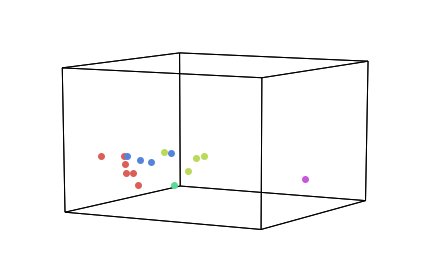

In [97]:
labels = hyp.tools.cluster(dat,n_clusters=5)
hyp.plot(dat,'o',group=labels);

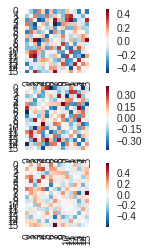

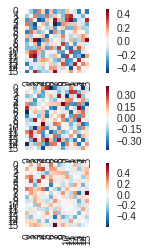

In [32]:
adj = Adjacency(roi_corrs)
adj.plot()

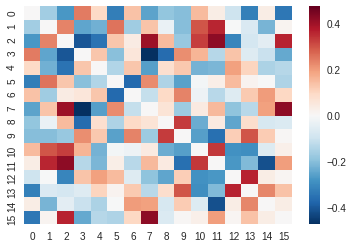

In [24]:
sns.heatmap(squareform(1-pdist(data[:,0,:],metric='correlation')))